# DETR

In [1]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

In [2]:
# Solo necesario en caso de problemas con los certificados SSL
import os
import certifi
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
os.environ['HF_HOME'] = 'D:\\huggingface_cache' # Cambia esta ruta a la que prefieras

In [6]:
# Agregamos una prueba para verificar si estamos usando cuda o cpu
# e imprimimos el dispositivo que se está utilizando así como su nombre

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Dispositivo utilizado:", device)
if device == "cuda":
    print("Nombre del dispositivo:", torch.cuda.get_device_name(0))

Dispositivo utilizado: cpu


In [7]:
# Cargamos la imagen de ejemplo de una URL
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)


In [8]:
# Cargamos el modelo preentrenado y el procesador
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm").to(device)    

# Preparamos la imagen para el modelo
inputs = processor(images=image, return_tensors="pt").to(device)

# Realizamos la inferencia
outputs = model(**inputs)

In [9]:
# Post-procesamos los resultados
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

In [10]:
# Imprimimos los resultados, incluyendo las etiquetas, las puntuaciones de confianza y las cajas delimitadoras
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


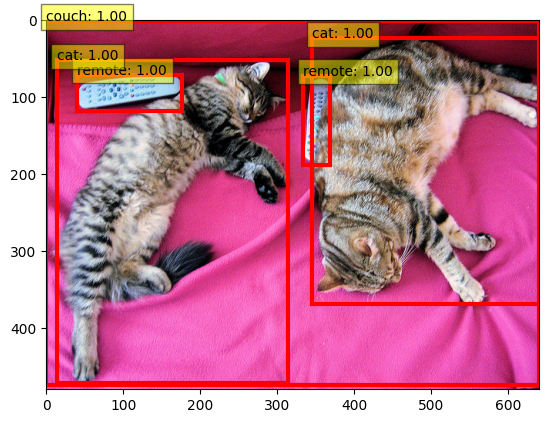

In [11]:
# Opcional: Visualizamos los resultados (se requiere de matplotlib)
import matplotlib.pyplot as plt

def plot_results(pil_img, scores, labels, boxes):
    plt.imshow(pil_img)
    ax = plt.gca()
    for score, label, box in zip(scores, labels, boxes):
        xmin, ymin, xmax, ymax = box.tolist()
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='red', linewidth=3))
        ax.text(xmin, ymin, f'{model.config.id2label[label.item()]}: {score:.2f}',
                bbox=dict(facecolor='yellow', alpha=0.5), fontsize=10)
    plt.show()

plot_results(image, results["scores"], results["labels"], results["boxes"])